In [2]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.colors as colors
import scipy.io

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\esl26\AppData\Local\Temp\ipykernel_31008\2781205995.py:1: SyntaxWarning: invalid escape sequence '\A'
  shp = gpd.read_file('../data/angola_shp\AGO_adm0.shp')


<Axes: >

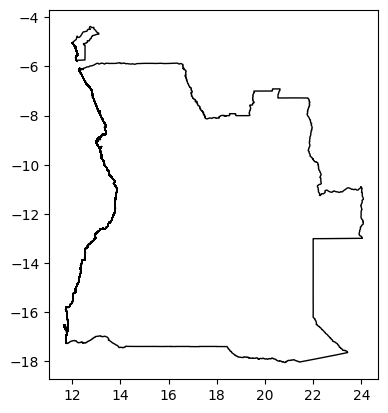

In [47]:
shp = gpd.read_file('../data/angola_shp\AGO_adm0.shp')
shp.geometry.boundary.plot(color=None, edgecolor='k', linewidth = 1)

In [3]:
type(shp.geometry.values[0]), shp.crs, shp.total_bounds

(shapely.geometry.multipolygon.MultiPolygon,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 array([ 11.66847324, -18.04208183,  24.08211708,  -4.37259102]))

In [4]:
tif_sample1 = "../data/rzsm/2015_04_20.tif"
with rio.open(tif_sample1) as src:
    sm = src.read(1)
    bounds = src.bounds
    crs = src.crs
sm.shape, bounds, crs

((189, 133),
 BoundingBox(left=11.716805458068848, bottom=-17.973846435546875, right=24.040456771850586, top=-4.4174346923828125),
 CRS.from_epsg(4326))

In [ ]:
values = np.unique(sm)[:-1] # remove the NaN value
values, np.min(values), np.max(values)

# Visualize TIFF file

In [70]:
def viz_tiff(date):
    tif_sample = f"../data/rzsm/{date}.tif"
    with rio.open(tif_sample) as src:
        sm = src.read(1)
        bounds = src.bounds
        crs = src.crs
    fig = plt.figure(figsize=(10, 10))
    img_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.epsg(3857)) 

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray',
                    alpha=0.5, linestyle='--', ylabel_style={'size': 14, 'rotation': 'vertical'}, 
                    xlabel_style={'size': 14}) #TODO: insert line styles later

    gl.xlabels_bottom = False
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.ylabels_right = False

    plot = ax.imshow(sm, cmap='GnBu', extent=img_extent)
    shp.geometry.boundary.plot(ax=ax, color='black', linewidth = 1)

    cbar_ax = fig.add_axes([0.20, 0.05, 0.6, 0.04])
    cbar = plt.colorbar(plot, cax=cbar_ax, orientation='horizontal', pad=0.05)
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('RZSM', fontsize=18)

    fig.suptitle(f'{date}', fontsize=20)

    # plt.savefig(f'../figures/rzsm_{date}.png', dpi=300, bbox_inches='tight')

c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated.

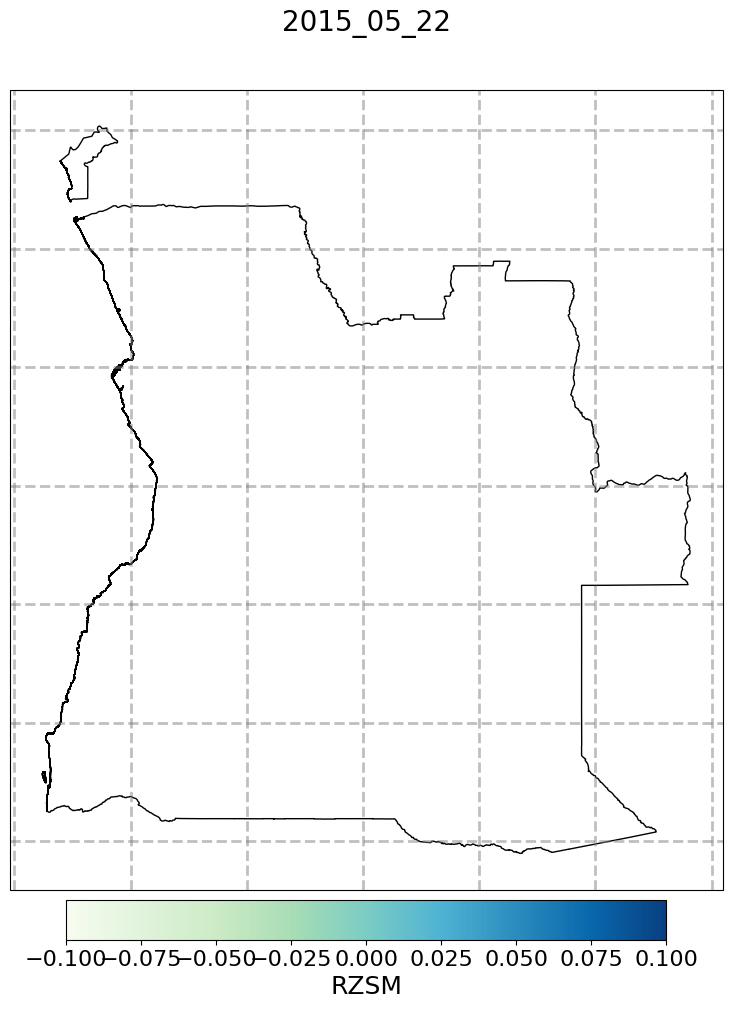

In [93]:
viz_tiff('2015_05_22')

## Visualize TIFF (Monthly)

In [74]:
# Let's create a colormap with 5 colors, to match the drought levels (USDM)
custom_colors = [
    "white",
    "yellow",
    "#FFDAB9",
    "orange",
    "red",
    "darkred",
]
cmap = colors.ListedColormap(custom_colors)

In [96]:
def viz_tiff_monthly(date):
    tif_sample = f"../data/monthly_drought_labels/{date}.tif"
    with rio.open(tif_sample) as src:
        label = src.read(1)
        bounds = src.bounds
        crs = src.crs
    fig = plt.figure(figsize=(10, 10))
    img_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.epsg(3857)) 

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray',
                    alpha=0.5, linestyle='--', ylabel_style={'size': 14, 'rotation': 'vertical'}, 
                    xlabel_style={'size': 14}) #TODO: insert line styles later

    gl.xlabels_bottom = False
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.ylabels_right = False

    plot = ax.imshow(label, cmap=cmap, extent=img_extent)
    shp.geometry.boundary.plot(ax=ax, color='black', linewidth = 1)

    cbar_ax = fig.add_axes([0.20, 0.05, 0.6, 0.04])
    cbar = plt.colorbar(plot, cax=cbar_ax, orientation='horizontal', pad=0.05)
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('USDM Drought Categories', fontsize=18)
    cbar.set_ticklabels(['None', 'D0','D1','D2','D3','D4'])
    cbar.set_ticks(np.linspace(0.35,3.65,6))

    fig.suptitle(f'{date}', fontsize=20)

    plt.savefig(f'../figures/drought_label_{date}.png', dpi=300, bbox_inches='tight')

c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated.

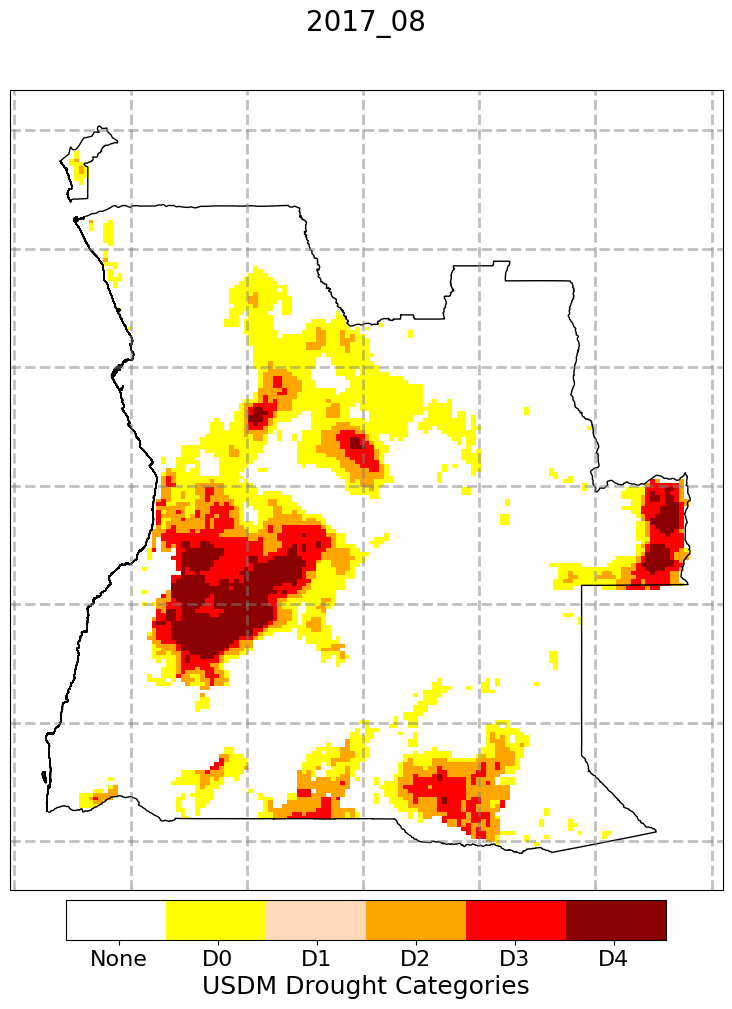

In [97]:
viz_tiff_monthly('2017_08')

# Porosity data
We have to convert the `porosity_9km.mat` file to numpy array

In [166]:
mat1 = scipy.io.loadmat('../data/porosity/porosityAfrica.mat')
mat2 = scipy.io.loadmat('../data/porosity/porosityAngola.mat')

In [167]:
porosity_africa = mat1['porosityAfrica']
porosity_angola = mat2['porosityAngola']
# porosity_africa
# porosity_angola

array([(array([[nan, nan, nan, ..., nan, nan, nan],
              [nan, nan, nan, ..., nan, nan, nan],
              [nan, nan, nan, ..., nan, nan, nan],
              ...,
              [nan, nan, nan, ..., nan, nan, nan],
              [nan, nan, nan, ..., nan, nan, nan],
              [nan, nan, nan, ..., nan, nan, nan]]), MatlabOpaque([(b'', b'MCOS', b'datetime', array([[3707764736],
                            [         2],
                            [         1],
                            [         1],
                            [         1],
                            [         1]], dtype=uint32))            ],
                    dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]), MatlabOpaque([(b'', b'MCOS', b'datetime', array([[3707764736],
                            [         2],
                            [         1],
                            [         1],
                            [         2],
                            [         1]], dtype=uint32)

In [168]:
porosity_angola.shape

(189, 133)

## Check the contents of the MATLAB files (porosity for Africa and Angola)

C:\Users\esl26\AppData\Local\Temp\ipykernel_43548\824297936.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


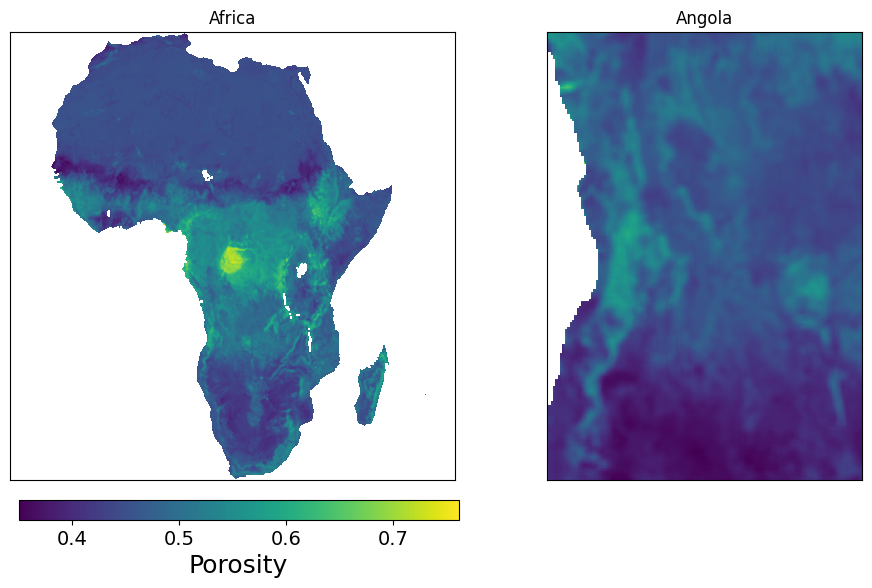

In [188]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot1 = axes[0].imshow(porosity_africa)
axes[0].set_title('Africa')
axes[0].set_xticks([])
axes[0].set_yticks([])

plot2 = axes[1].imshow(porosity_angola)
axes[1].set_title('Angola')
axes[1].set_xticks([])
axes[1].set_yticks([])

cbar_ax = fig.add_axes([0.05, -0.05, 0.44, 0.04])
cbar = plt.colorbar(plot1, cax=cbar_ax, orientation='horizontal', pad=0.05)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Porosity', fontsize=18)
fig.tight_layout()

## Check the porosity in Angola

c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


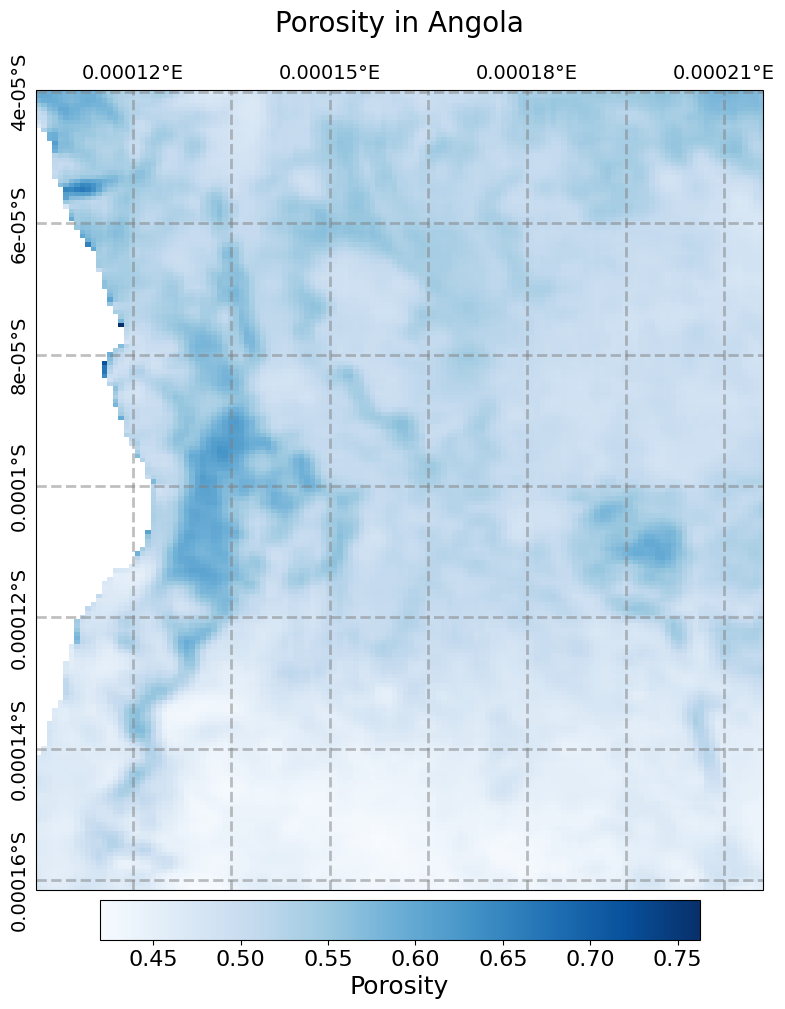

In [311]:
fig = plt.figure(figsize=(10, 10))
img_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.epsg(3857)) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray',
                alpha=0.5, linestyle='--', ylabel_style={'size': 14, 'rotation': 'vertical'}, 
                xlabel_style={'size': 14}) #TODO: insert line styles later

gl.xlabels_bottom = False
gl.ylabels_right = False

plot = ax.imshow(porosity_angola, cmap='Blues', extent=img_extent)

cbar_ax = fig.add_axes([0.20, 0.05, 0.6, 0.04])
cbar = plt.colorbar(plot, cax=cbar_ax, orientation='horizontal', pad=0.05)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Porosity', fontsize=18)

fig.suptitle("Porosity in Angola", fontsize=20)

plt.savefig(f'../figures/porosity_angola.png', dpi=300, bbox_inches='tight')

## Drought Severity Index

Starting with the file, `RZSM_withDroughtLabels_Angola_8day.mat`

In [14]:
mat = scipy.io.loadmat('../data/RZSM_withDroughtLabels_Angola_8day.mat')
rszm_angola_structs = mat['RZSM_Angola'][0]

In [19]:
rszm_angola_structs['droughtLabels'][0].shape

(189, 133)

In [305]:
rszm_angola_structs[5][1]['arr']

MatlabOpaque([array([[3707764736],
                     [         2],
                     [         1],
                     [         1],
                     [        16],
                     [         1]], dtype=uint32)], dtype=object)

In [207]:
# Let's create a colormap with 5 colors, to match the drought levels (USDM)
custom_colors = [
    "yellow",
    "#FFDAB9",
    "orange",
    "red",
    "darkred",
]
cmap = colors.ListedColormap(custom_colors)

c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\esl26\AppData\Local\Temp\ipykernel_43548\1509590264.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(['D0','D1','D2','D3','D4'])


Text(0.5, 0.98, 'Insert date')

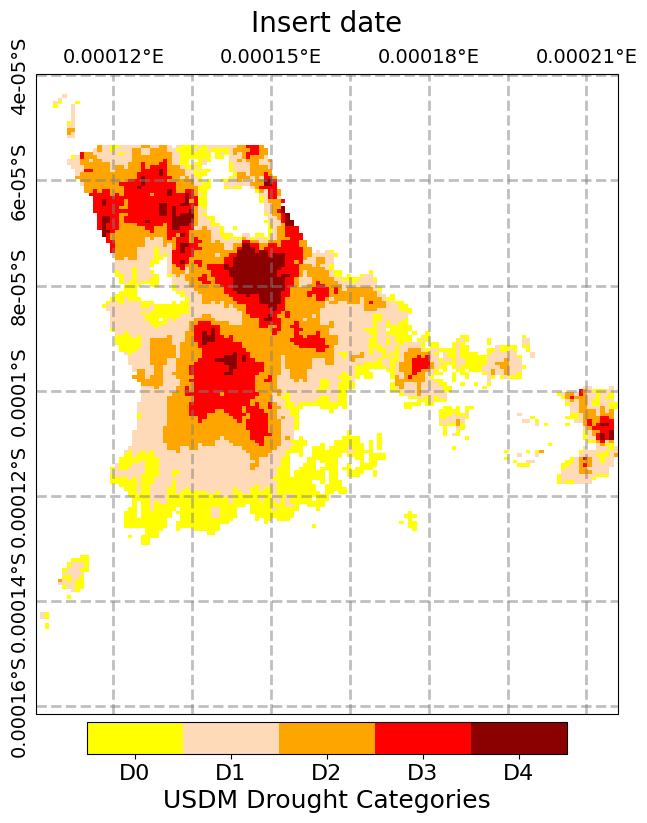

In [310]:
fig = plt.figure(figsize=(8, 8))
img_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.epsg(3857)) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray',
                alpha=0.5, linestyle='--', ylabel_style={'size': 14, 'rotation': 'vertical'}, 
                xlabel_style={'size': 14}) #TODO: insert line styles later

gl.xlabels_bottom = False
gl.ylabels_right = False

plot = ax.imshow(rszm_angola_structs[90]['droughtLabels'], extent=img_extent, cmap=cmap)

cbar_ax = fig.add_axes([0.20, 0.05, 0.6, 0.04])
cbar = plt.colorbar(plot, cax=cbar_ax, orientation='horizontal', pad=0.05)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('USDM Drought Categories', fontsize=18)
cbar.set_ticklabels(['D0','D1','D2','D3','D4'])
cbar.set_ticks(np.linspace(0.4,3.6,5))

fig.suptitle("Insert date", fontsize=20)

# plt.savefig(f'../figures/porosity_angola.png', dpi=300, bbox_inches='tight')